In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# For use on local machine
%cd ..

C:\Users\efurst1\PycharmProjects\LIDC_GDRO


In [2]:
# For use in google colab
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd LIDC_GDRO/

Cloning into 'LIDC_GDRO'...
remote: Enumerating objects: 3777, done.
remote: Counting objects: 100% (349/349), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 3777 (delta 210), reused 295 (delta 174), pack-reused 3428
Receiving objects: 100% (3777/3777), 82.66 MiB | 14.68 MiB/s, done.
Resolving deltas: 100% (3358/3358), done.
Checking out files: 100% (5414/5414), done.
/content/LIDC_GDRO


In [3]:
!git pull

Already up to date.


In [4]:
import data_util
import datasets
import dataloaders
import models
import torch
import loss
import train
import pandas as pd
import numpy as np
import torchvision

In [5]:
class TransferModel18(torch.nn.Module):

    def __init__(self, pretrained=True, freeze=True, binary = True, device='cpu'):
        super(TransferModel18, self).__init__()

        self.model = torchvision.models.resnet18(pretrained=pretrained).to(device)
        
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False


            # for param in self.model.layer4.parameters():
            #     param.requires_grad = True
        
        out_feats = 2 if binary else 4
        self.model.fc = torch.nn.Sequential(
          torch.nn.Linear(in_features=512, out_features=36, bias=True, device=device),
          torch.nn.ReLU(inplace=True),
          # nn.Dropout(p=0.5, inplace=False),
          torch.nn.Linear(in_features=36, out_features=out_feats, bias=True, device=device)
        )

        for layer in self.model.fc:
            if hasattr(layer, 'weight'):
                torch.nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        return self.model(x).squeeze()


class TransferModel50(torch.nn.Module):

    def __init__(self, pretrained=True, freeze=True, binary = True, device='cpu'):
        super(TransferModel50, self).__init__()

        self.model = torchvision.models.resnet50(pretrained=pretrained).to(device)
        
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False


            # for param in self.model.layer4.parameters():
            #     param.requires_grad = True
        
        out_feats = 2 if binary else 4
        self.model.fc = torch.nn.Sequential(
          torch.nn.Linear(in_features=2048, out_features=out_feats, bias=True, device=device),
        )

        for layer in self.model.fc:
            if hasattr(layer, 'weight'):
                torch.nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        return self.model(x).squeeze()

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 128

hparams = {"eta": 0.05, "gamma": 1}
lr = 0.001
weight_decay = 0.0001
momentum = 0.9

# model_class = models.NeuralNetwork
# model_args = (64, 36, 36, 2)

model_class = TransferModel50
model_args = (True, False, True, device)


print(f'Using device {device}')

Using device cuda


# Load and process data

## LIDC

In [ ]:
# get LIDC data

df = data_util.preprocess_data(*data_util.load_lidc())
df

,noduleID,Area,ConvexArea,Perimeter,ConvexPerimeter,EquivDiameter,MajorAxisLength,MinorAxisLength,Elongation,Compactness,...,Energy,Homogeneity,Entropy,x_3rdordermoment,Inversevariance,Sumaverage,Variance,Clustertendency,malignancy,subgroup
0,1,2.786989,2.787828,2.621314,2.454225,2.468314,2.096066,2.748694,-0.570518,1.280735,...,-0.941970,1.182771,1.901636,-0.237301,1.094495,0.581531,-0.074923,0.036838,1,marked_malignant
1,2,2.208070,1.860850,1.503739,1.900692,2.116778,2.028013,1.857099,0.368191,-0.184960,...,-0.907012,1.393682,1.579543,-0.063547,1.072152,-1.152443,-0.649761,-0.649261,1,unmarked_malignant
2,3,2.250831,2.167998,2.131948,1.986969,2.143839,1.822497,2.130987,-0.259140,0.917787,...,-0.924491,1.423812,1.802531,-0.247131,1.362616,-0.477880,-0.241693,-0.158040,1,marked_malignant
3,4,-0.281938,-0.308556,-0.169450,-0.131188,-0.112305,-0.035113,-0.254287,0.706877,-0.144326,...,-0.522478,-0.142953,0.150768,-0.268456,-0.201422,-0.460583,-0.305796,-0.298158,1,marked_malignant
4,5,-0.002347,-0.076120,0.004412,0.124439,0.266908,-0.017849,0.457045,-1.040008,-0.500777,...,-0.679787,2.580808,0.481121,-0.107827,2.982511,0.166415,-0.106192,-0.042079,1,unmarked_malignant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,2686,0.849585,1.069459,1.451416,1.508525,1.126116,1.302069,1.377140,-0.009162,1.618966,...,-0.907012,0.574143,1.538249,-0.280163,0.290133,-0.162218,-0.100981,-0.013089,1,marked_malignant
2682,2687,-0.258913,-0.275351,-0.121906,-0.106743,-0.077760,-0.020100,-0.174450,0.471571,-0.060785,...,-0.522478,1.122511,0.167286,-0.248991,1.049808,-1.303787,-0.645070,-0.636376,1,marked_malignant
2683,2688,-0.624027,-0.601868,-0.690046,-0.740736,-0.762772,-0.713385,-0.763129,0.053998,-0.310221,...,0.508773,-0.841972,-0.823771,0.099402,-1.072814,-0.265997,-0.278174,-0.315875,0,unmarked_benign
2684,2689,-0.614159,-0.601868,-0.678509,-0.736229,-0.737945,-0.788747,-0.650570,-0.818325,-0.352348,...,0.351464,0.164374,-0.724665,-0.272902,-0.391340,-1.325408,-0.727934,-0.757168,0,unmarked_benign


In [ ]:
sum(df['subgroup'] == "unmarked_malignant")# / len(df)

204

In [ ]:
sum(data_util.load_lidc()[0]['malignancy'] > 3) / len(data_util.load_lidc()[0])

0.22032005954596204

In [ ]:
# get train/test flags
train_test = pd.read_csv("data/lidc_train_test_split_stratified.csv")

# create train/test dataframes
training_df = df[df["noduleID"].isin(train_test[train_test["dataset"] == "train"]["noduleID"].values)]
test_df = df[df["noduleID"].isin(train_test[train_test["dataset"] == "test"]["noduleID"].values)]

In [ ]:
train_dataloader = data_util.create_dataloader(training_df, batch_size)
test_dataloader = data_util.create_dataloader(test_df, batch_size)

## Waterbirds

In [7]:
# download waterbirds through wilds

!pip install wilds
from wilds import get_dataset

get_dataset(dataset="waterbirds", download=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 15.3 MB/s 
     |████████████████████████████████| 78 kB 7.8 MB/s 
     |████████████████████████████████| 3.1 MB 64.4 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=18dd8b92f34ec21aeb7fe10fa2428e1998aedbdea54d953bff90dcb45b6793ad
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


You can also download the dataset manually at https://wilds.stanford.edu/downloads.


0Byte [00:00, ?Byte/s]

Extracting data/waterbirds_v1.0/archive.tar.gz to data/waterbirds_v1.0

It took 1.6 minutes to download and uncompress the dataset.



In [8]:
from PIL import Image

[autoreload of PIL.Image failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'DeferredError' from 'PIL._util' (/usr/local/lib/python3.7/dist-packages/PIL/_util.py)
]
[autoreload of PIL.ImageOps failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: module 'PIL.Image' has no attribute 'Resampling'
]


In [9]:
metadata_df = pd.read_csv('data/waterbirds_v1.0/metadata.csv')

In [10]:
class OnDemandWaterbirdsDataset(torch.utils.data.Dataset):
    def __init__(self, metadata, root_dir, transform, device):
        '''
        INPUTS:
        metadata: metadata dataframe storing the image paths, labels, and subclasses
        root_dir: the directory where the image files are stored
        transform: the transform to apply to the image when it is loaded
        device to move tensors to as they are loaded

        '''

        self.metadata = metadata
        self.root_dir = root_dir
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # column 1: image path
        img_path = self.metadata.iloc[idx, 1]
        img_tensor = self.transform(Image.open(self.root_dir + img_path)).squeeze().to(self.device)

        # column 2: image label
        label = torch.LongTensor([self.metadata.iloc[idx, 2]]).squeeze().to(self.device)

        # column 4 contains the confounding label, which is combined with column 2 to get the subclass
        subclass = torch.LongTensor([2 * self.metadata.iloc[idx, 2] + self.metadata.iloc[idx, 4]]).squeeze().to(self.device)

        return img_tensor, label, subclass

In [11]:
convert_resize = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((200, 200), antialias=True)])

train_df, val_df, test_df = [metadata_df[metadata_df['split'] == split] for split in [0, 1, 2]]

dataset_list = []

for df in [train_df, val_df, test_df]:
    dataset_list.append(OnDemandWaterbirdsDataset(df, 'data/waterbirds_v1.0/', transform=convert_resize, device=device))

In [12]:
# smaller dataloaders for prototyping
train_dataloader, test_dataloader, _ = [dataloaders.InfiniteDataLoader(torch.utils.data.Subset(dataset, range(0, len(dataset), 2)), batch_size=batch_size) for dataset in dataset_list]

In [ ]:
# full size dataloaders
train_dataloader, test_dataloader, _ = [dataloaders.InfiniteDataLoader(dataset, batch_size=batch_size) for dataset in dataset_list]


# Test convergence of combinations of ERM and GDRO

In [18]:
N = 1
epochs = 60
# subtypes = ["Overall", "Unspiculated benign", "Spiculated benign", "Spiculated malignant", "Unspiculated malignant"]
subtypes = ["Overall", "Land on land", "Land on water", "Water on land", "Water on water"]

# test_algorithms = ["ERM", "GDRO", "Sharp", "Smooth", "ReverseSmooth", "Dynamic", "ExtraERM", "ExtraGDRO", "Halfway"]
# test_algorithms = ["Mix" + str(t) for t in [0.4, 0.5, 0.6, 0.7, 0.8]]
# test_algorithms = ["ERM", "GDRO", *["Dynamic" + str(t) for t in [0.01, 0.05, 0.1, 0.5]]]
test_algorithms = ["ERM", "GDRO", "Dynamic", "Upweight"]
keep_old =        [True, True, False, False]

In [19]:
if not sum(keep_old):
    results = {}

for a in range(len(test_algorithms)):
    algorithm = test_algorithms[a]

    if keep_old[a] and algorithm in results:
        print(f"Keeping old results for {algorithm}")
    else:
        print(f"Running test: {algorithm}")

        results[algorithm] = np.zeros(N * epochs * len(subtypes))

        for n in range(N):

            print(f"Trial {n + 1}/{N}")

            # create and train model
            # model = models.NeuralNetwork(64, 32, 32, 2)
            # model.to(device)
            model = model_class(*model_args)

            if (algorithm == "ERM"):
                loss_fn = loss.ERMLoss(model, torch.nn.CrossEntropyLoss(), hparams, subclassed=True)
            elif (algorithm == "GDRO"):
                loss_fn = loss.GDROLossAlt(model, torch.nn.CrossEntropyLoss(), hparams["eta"], 4, normalize_loss=False)
            elif (algorithm == "NormGDRO"):
                loss_fn = loss.GDROLossAlt(model, torch.nn.CrossEntropyLoss(), hparams["eta"], 4, normalize_loss=True)
            elif (algorithm.startswith("GDRO")):
                loss_fn = loss.GDROLossAlt(model, torch.nn.CrossEntropyLoss(), float(algorithm[len("GDRO"):]), 4, normalize_loss=True)
            elif (algorithm == "Dynamic"):
                loss_fn = loss.DynamicERMGDROLossAlt(model, torch.nn.CrossEntropyLoss(), hparams["eta"], hparams["gamma"], 4)
            elif (algorithm.startswith("Dynamic")):
                loss_fn = loss.DynamicERMGDROLossAlt(model, torch.nn.CrossEntropyLoss(), float(algorithm[len("Dynamic"):]), hparams["gamma"], 4)
            elif (algorithm == "Upweight"):
                loss_fn = loss.UpweightSmall(model, torch.nn.CrossEntropyLoss(), 4)
            else:
                loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams, 4)
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)

            for epoch in range(epochs):
                print(f'Epoch {epoch + 1} / {epochs}')

                if algorithm == "Sharp":
                    loss_fn.t = epoch / epochs < 0.5  # sharp boundary
                elif algorithm == "Smooth":
                    loss_fn.t = 1 - (epoch / (epochs - 1))  # linear interpolation
                elif algorithm == "ReverseSmooth":
                    loss_fn.t = epoch / (epochs - 1)  # reverse linear interpolation
                elif algorithm == "ExtraERM":
                    loss_fn.t = 2
                elif algorithm == "ExtraGDRO":
                    loss_fn.t = -1
                elif algorithm == "Halfway":
                    loss_fn.t = 0.5
                elif algorithm.startswith("Mix"):
                    loss_fn.t = float(algorithm[3:])  # ex. algorithm == "Mix0.5" => t = 0.5

                train.train(train_dataloader, model, loss_fn, optimizer)
                sensitivities = train.test(test_dataloader, model, num_subclasses=4)

                for i in range(len(subtypes)):
                    results[algorithm][n * epochs * len(subtypes) + epoch * len(subtypes) + i] = sensitivities[i]

print("Test complete")

results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

results_df.to_csv('results.csv')

from google.colab import files
files.download('results.csv') 

Keeping old results for ERM
Keeping old results for GDRO
Running test: Dynamic
Trial 1/1


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 / 60
Epoch 2 / 60
Epoch 3 / 60
Epoch 4 / 60
Epoch 5 / 60
Epoch 6 / 60
Epoch 7 / 60
Epoch 8 / 60
Epoch 9 / 60
Epoch 10 / 60
Epoch 11 / 60
Epoch 12 / 60
Epoch 13 / 60
Epoch 14 / 60
Epoch 15 / 60
Epoch 16 / 60
Epoch 17 / 60
Epoch 18 / 60
Epoch 19 / 60
Epoch 20 / 60
Epoch 21 / 60
Epoch 22 / 60
Epoch 23 / 60
Epoch 24 / 60
Epoch 25 / 60
Epoch 26 / 60
Epoch 27 / 60
Epoch 28 / 60
Epoch 29 / 60
Epoch 30 / 60
Epoch 31 / 60
Epoch 32 / 60
Epoch 33 / 60
Epoch 34 / 60
Epoch 35 / 60
Epoch 36 / 60
Epoch 37 / 60
Epoch 38 / 60
Epoch 39 / 60
Epoch 40 / 60
Epoch 41 / 60
Epoch 42 / 60
Epoch 43 / 60
Epoch 44 / 60
Epoch 45 / 60
Epoch 46 / 60
Epoch 47 / 60
Epoch 48 / 60
Epoch 49 / 60
Epoch 50 / 60
Epoch 51 / 60
Epoch 52 / 60
Epoch 53 / 60
Epoch 54 / 60
Epoch 55 / 60
Epoch 56 / 60
Epoch 57 / 60
Epoch 58 / 60
Epoch 59 / 60
Epoch 60 / 60
Running test: Upweight
Trial 1/1
Epoch 1 / 60
Epoch 2 / 60
Epoch 3 / 60
Epoch 4 / 60
Epoch 5 / 60
Epoch 6 / 60
Epoch 7 / 60
Epoch 8 / 60
Epoch 9 / 60
Epoch 10 / 60
Epoch

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

In [21]:
results_df

ERM      GDRO   Dynamic  Upweight
trial epoch subtype                                               
0     0     Overall         0.576172  0.759766  0.568359  0.886719
            Land on land    0.922222  0.798817  0.938889  0.940828
            Land on water   0.244019  0.688372  0.114833  0.920930
            Water on land   0.349206  0.830769  0.661538  0.644068
            Water on water  0.933333  0.825397  0.948276  0.855072
...                              ...       ...       ...       ...
      59    Overall         0.775391  0.828125  0.771484  0.828125
            Land on land    1.000000  0.994624  1.000000  0.975000
            Land on water   0.625000  0.752336  0.652582  0.701031
            Water on land   0.426230  0.413043  0.333333  0.666667
            Water on water  0.909091  0.893939  0.900000  0.901639

[300 rows x 4 columns]

In [22]:
worst_group = results_df.stack().unstack(level=2).min(axis=1).unstack()
worst_group.index = pd.MultiIndex.from_tuples([(*idx, "Worst") for idx in worst_group.index], names=["trial", "epoch", "subtype"])
worst_group

ERM      GDRO   Dynamic  Upweight
trial epoch subtype                                        
0     0     Worst    0.244019  0.688372  0.114833  0.644068
      1     Worst    0.207547  0.528302  0.256410  0.577778
      2     Worst    0.404762  0.519231  0.450980  0.690141
      3     Worst    0.571429  0.629630  0.436364  0.657143
      4     Worst    0.448980  0.716981  0.439024  0.702128
      5     Worst    0.360000  0.586207  0.460000  0.546875
      6     Worst    0.425532  0.632653  0.469388  0.714286
      7     Worst    0.406780  0.549020  0.413043  0.685185
      8     Worst    0.470588  0.636364  0.450000  0.692308
      9     Worst    0.454545  0.582090  0.327273  0.593220
      10    Worst    0.333333  0.450980  0.530612  0.634615
      11    Worst    0.369565  0.577778  0.469388  0.741379
      12    Worst    0.508772  0.477273  0.510204  0.616667
      13    Worst    0.382979  0.615385  0.493506  0.550000
      14    Worst    0.438596  0.660377  0.465517  0.646154
      15    Worst    0.465116  0.591837  0.468085  0.645833
      16    Worst    0.437500  0.588235  0.295455  0.772727
      17    Worst    0.584906  0.588235  0.468085  0.645161
      18    Worst    0.379310  0.550000  0.454545  0.600000
      19    Worst    0.363636  0.555556  0.444444  0.619048
      20    Worst    0.565789  0.578947  0.418182  0.644444
      21    Worst    0.452830  0.596774  0.317073  0.629630
      22    Worst    0.446429  0.632653  0.354839  0.571429
      23    Worst    0.461538  0.545455  0.422222  0.633333
      24    Worst    0.489362  0.425926  0.459016  0.750000
      25    Worst    0.440000  0.551020  0.448276  0.578947
      26    Worst    0.456140  0.547170  0.476190  0.511628
      27    Worst    0.450980  0.581818  0.389831  0.549020
      28    Worst    0.490909  0.586207  0.307692  0.703704
      29    Worst    0.326087  0.603774  0.385965  0.618182
      30    Worst    0.428571  0.480000  0.491228  0.555556
      31    Worst    0.454545  0.508197  0.340909  0.521739
      32    Worst    0.381818  0.400000  0.545455  0.568627
      33    Worst    0.511111  0.580645  0.404255  0.576271
      34    Worst    0.460317  0.581395  0.500000  0.532258
      35    Worst    0.490566  0.440000  0.431373  0.606557
      36    Worst    0.375000  0.528302  0.446809  0.603175
      37    Worst    0.437500  0.452830  0.596774  0.640000
      38    Worst    0.428571  0.623894  0.611111  0.705882
      39    Worst    0.458333  0.508772  0.456522  0.610169
      40    Worst    0.380000  0.568627  0.327586  0.767442
      41    Worst    0.279070  0.538462  0.482759  0.487805
      42    Worst    0.346939  0.672811  0.491228  0.728814
      43    Worst    0.574074  0.528302  0.415094  0.728814
      44    Worst    0.365385  0.500000  0.422222  0.614035
      45    Worst    0.490196  0.593301  0.361702  0.704225
      46    Worst    0.549020  0.665025  0.492308  0.604651
      47    Worst    0.474576  0.509804  0.440000  0.648148
      48    Worst    0.500000  0.608696  0.420000  0.520833
      49    Worst    0.311111  0.557692  0.418182  0.500000
      50    Worst    0.484848  0.510204  0.318182  0.641509
      51    Worst    0.543478  0.634921  0.512195  0.620690
      52    Worst    0.532258  0.549020  0.400000  0.636364
      53    Worst    0.468750  0.527273  0.524590  0.553571
      54    Worst    0.288462  0.630435  0.470588  0.750000
      55    Worst    0.491228  0.591837  0.403226  0.533333
      56    Worst    0.424242  0.692982  0.420000  0.574074
      57    Worst    0.375000  0.641509  0.434783  0.557692
      58    Worst    0.425926  0.510638  0.395349  0.678571
      59    Worst    0.426230  0.413043  0.333333  0.666667

In [23]:
worst_concat = pd.concat([results_df, worst_group])
trial_means = worst_concat.unstack().unstack().mean(axis=0).unstack(level=0).unstack(level=0).stack()

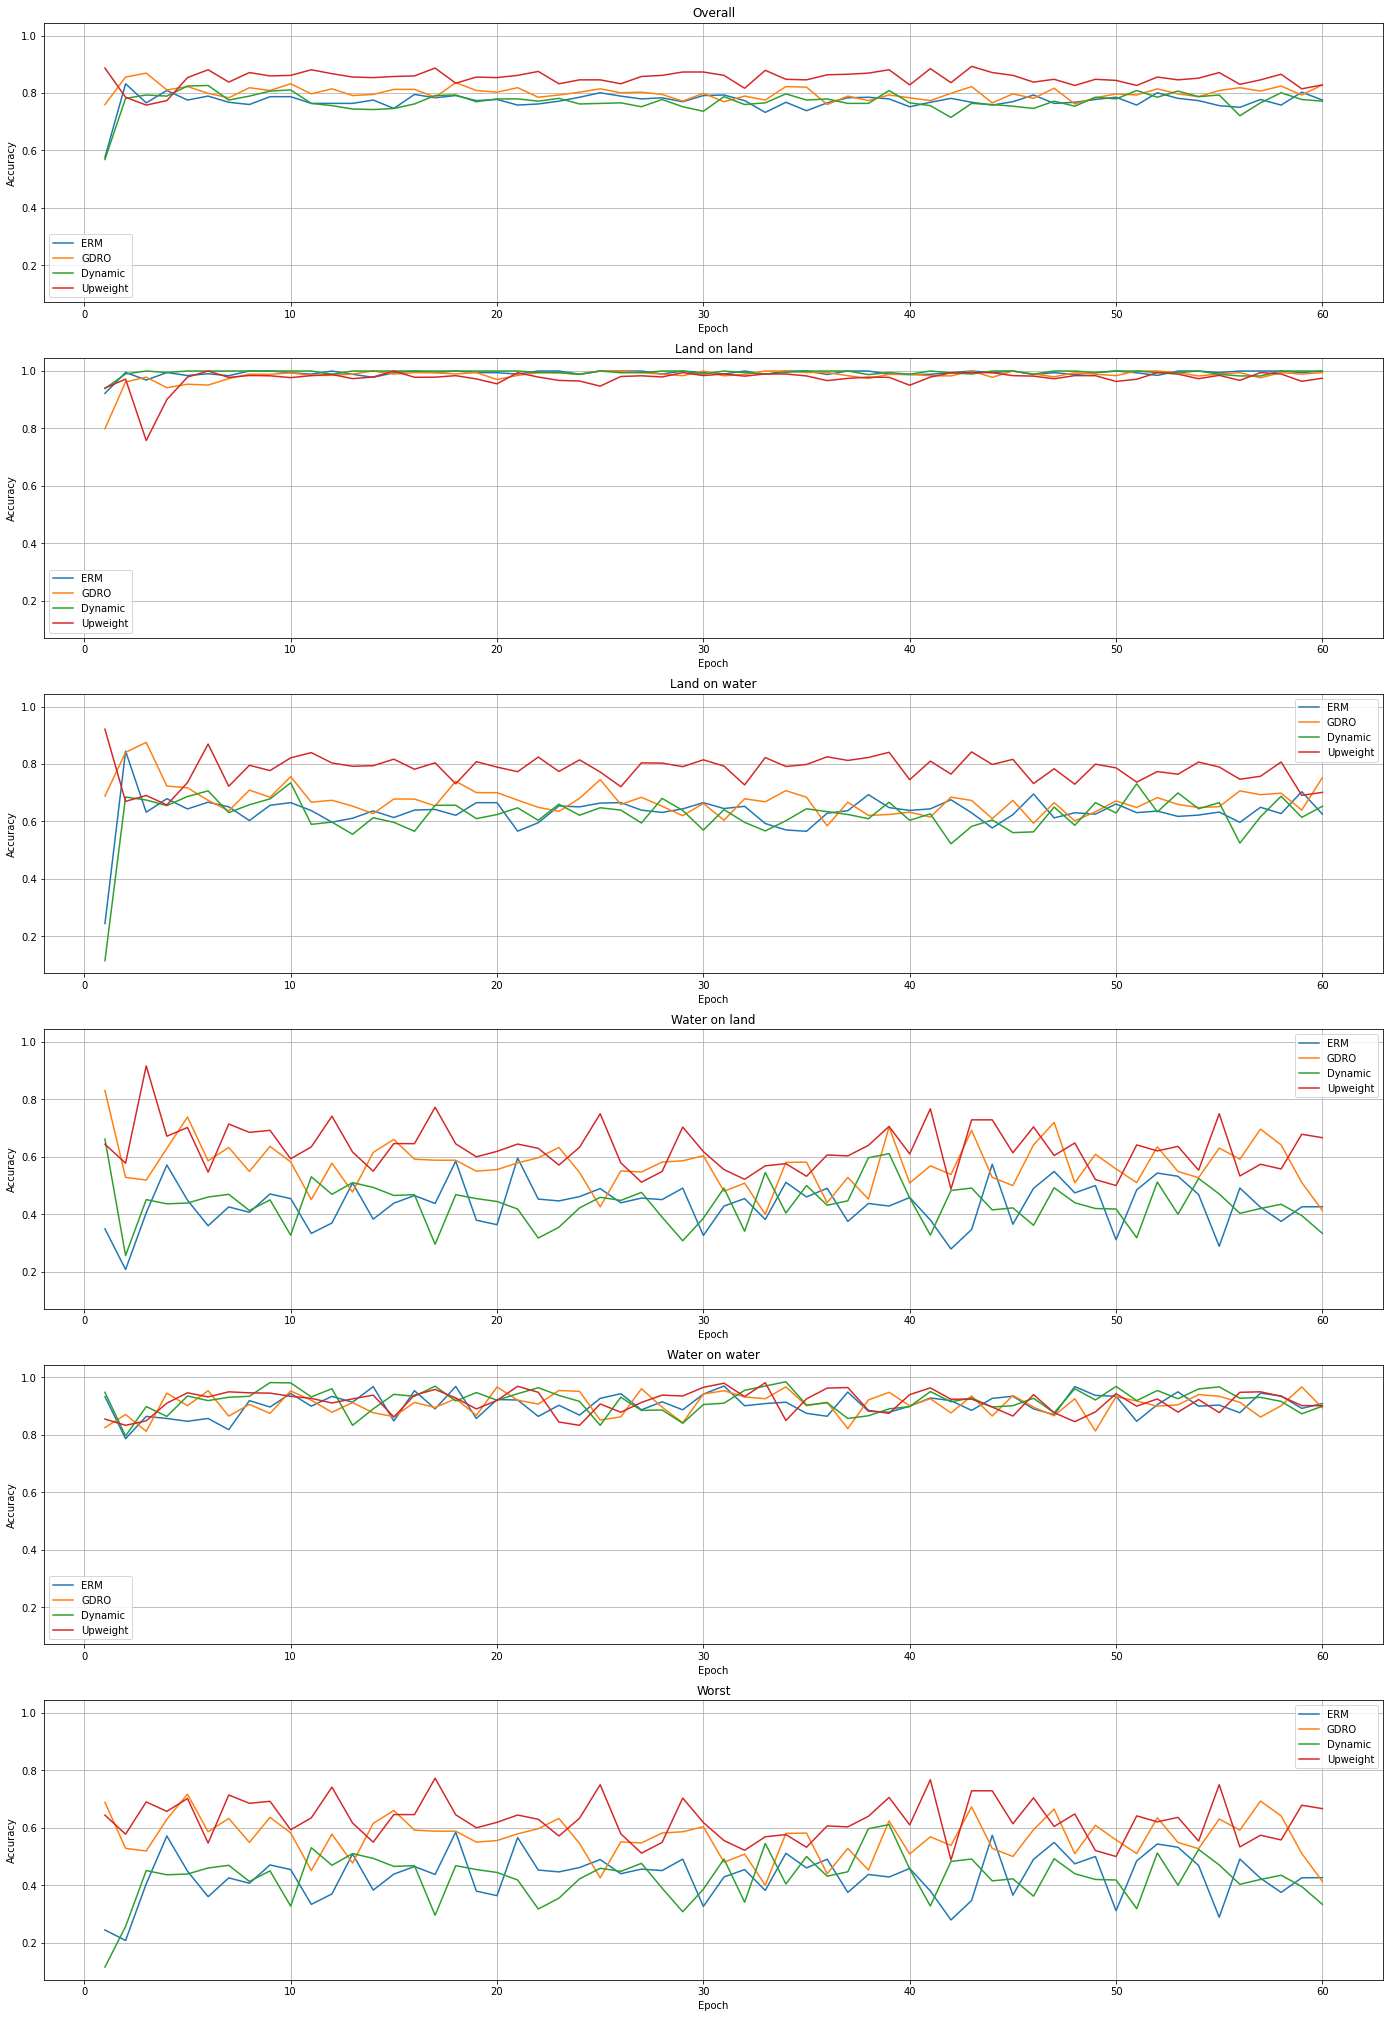

In [30]:
import matplotlib.pyplot as plt

rolling_window = 1

rolling_data = trial_means.unstack(level=1).rolling(rolling_window).mean().stack()
# reindex epochs from 1
rolling_data.index = pd.MultiIndex.from_tuples(zip(rolling_data.index.get_level_values(0) + 1, rolling_data.index.get_level_values(1)), names=["epoch", "subtype"])

plots = [*subtypes, "Worst"]

hide = []

# f, a = plt.subplots(len(plots),1, sharey=True)

f, a = plt.subplots(len(plots), 1, sharey=True)

# plot subtypes sensitivity

#legend=None,xlim=[55, 60],ylim=[0.85,0.88],

for i in range(len(plots)):
    rolling_data.drop(columns=hide).xs(plots[i], level=1).plot(xlabel="Epoch",ylabel="Accuracy",kind='line',title=plots[i],ax=a[i],figsize=(24,36),grid=True)

<AxesSubplot:title={'center':'worst'}>

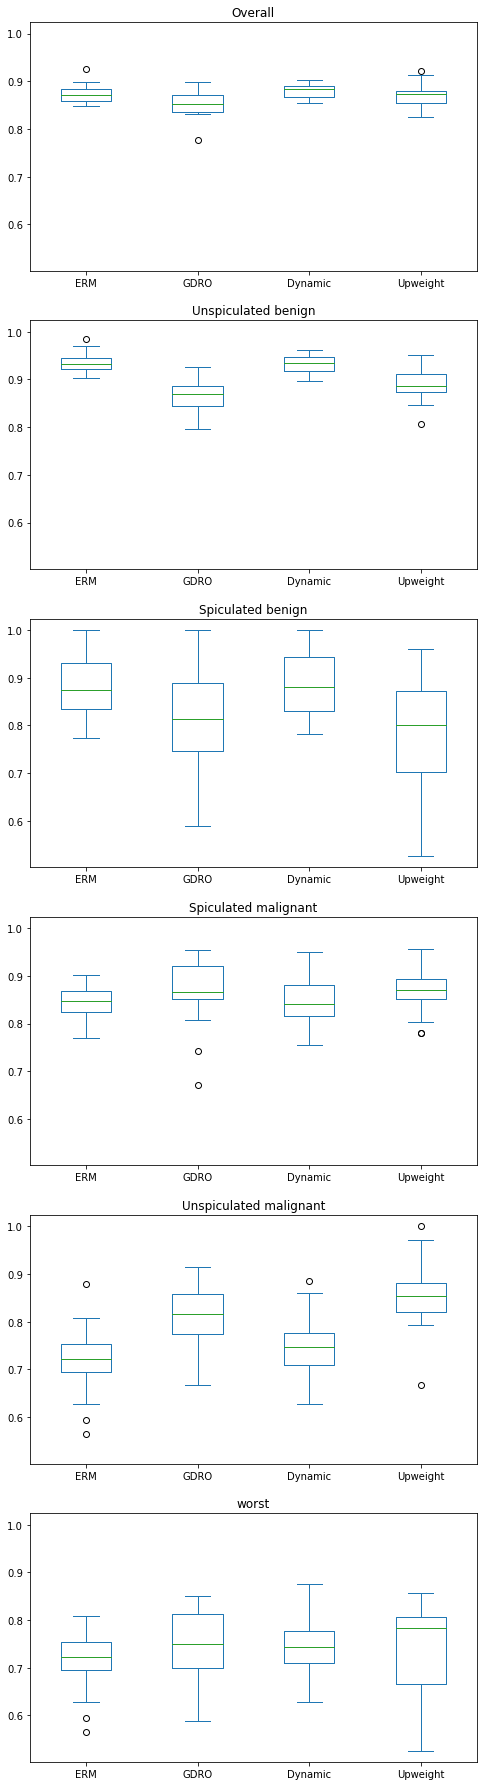

In [ ]:
# statisitical tests comparing to ERM
from scipy.stats import ttest_ind
from IPython.display import display
import seaborn as sns

significance_threshold = 0.05

ttest_dataframes = {}

f, a = plt.subplots(len(subtypes) + 1,1, sharey=True, figsize=(8,32))

for s in range(len(subtypes)):
#     print(subtype)
#     print()
    subtype_data = results_df.xs(subtypes[s], level=2).xs(epochs - 1, level=1)
    subtype_data.plot(title=subtypes[s], kind='box', ax=a[s])
    
# worst group data
results_df.stack().unstack(level=2).min(axis=1).unstack().xs(epochs - 1, level=1).plot(title='worst', kind='box', ax=a[-1])
    
    
#     erm_data = subtype_data["ERM"].values

#     for algorithm in results_df.columns:
#         algorithm_data = subtype_data[algorithm].values
#         stat, p = ttest_ind(algorithm_data, erm_data)
        
#         print(f'ERM: {erm_data.mean()}')
#         print(f'{algorithm}: {algorithm_data.mean()}')
#         if p < significance_threshold:
#             print(f'{algorithm if stat > 0 else "ERM"} greater with p = {p:.2f}')
#         else:
#             print(f'No significant difference with p = {p:.2f}')
#         print()
#     print()

In [ ]:
results_df.xs(subtype, level=2).xs(epochs - 1, level=1)

,ERM,GDRO,Dynamic,Upweight
trial,,,,
0,0.859375,0.898438,0.890625,0.855469
1,0.867188,0.843750,0.878906,0.847656
2,0.851562,0.867188,0.878906,0.855469
3,0.851562,0.851562,0.886719,0.914062
4,0.882812,0.832031,0.902344,0.882812
5,0.882812,0.832031,0.890625,0.847656
6,0.859375,0.894531,0.902344,0.859375
7,0.894531,0.777344,0.863281,0.921875
8,0.882812,0.832031,0.875000,0.871094


In [ ]:
# save results
results_df.to_csv('test_results/LIDC__fc64_36_36_2__Adam__eta_0_05__gamma_1_0__lr_0_001__weightdecay_0_0001__momentum_0_9.csv')

In [ ]:
loaded_df = pd.read_csv('test_results/waterbirds__resnet50__200x200__halfdata__Adam__eta_0_01__gamma_1_0__lr_0_001__weight_decay_0_0001__momentum_0_9.csv')
N = max(loaded_df["trial"]) + 1
epochs = max(loaded_df["epoch"]) + 1
subtypes = list(loaded_df["subtype"].unique())
algorithms = loaded_df.columns

results = loaded_df.drop(columns=["subtype", "epoch", "trial"]).to_dict('list')

# GDRO Demonstration

In [ ]:
epochs = 30
N = 1

q_data = {}

for n in range(N):

    q_data[f'Trial_{n}'] = []
    
    model = model_class(*model_args)

    loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams, len(subtypes) - 1, normalize_loss=True, subclassed=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    loss_fn.t = 0

    q_data[f'Trial_{n}'].extend([1 / (len(subtypes) - 1) for i in range(len(subtypes) - 1)])
    for epoch in range(epochs):
        train.train(train_dataloader, model, loss_fn, optimizer)
        q_data[f'Trial_{n}'].extend(loss_fn.gdro.q.tolist())

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
q_df = pd.DataFrame(q_data, index=pd.MultiIndex.from_product([range(epochs + 1), subtypes[1:]], names=['epoch', 'subtype'])).mean(axis=1).unstack()
# columns get rearranged into alphabetical order, this swaps them back
q_df = q_df[subtypes[1:]]

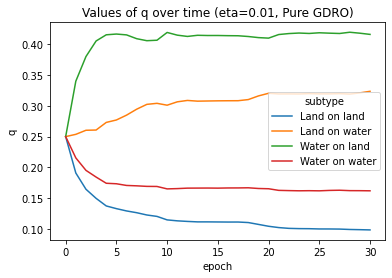

In [ ]:
q_df.plot(xlabel="epoch", ylabel="q", title=f"Values of q over time (eta={hparams['groupdro_eta']}, Pure GDRO)")

# Combining CNN features and engineered features

In [ ]:
cnn_df = pd.read_csv('data/cnn_features.csv')
for c in range(2, len(cnn_df.columns)):
    cnn_df.columns.values[c] = f'CNN_{cnn_df.columns.values[c]}'

eng_df = pd.read_csv('data/LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv')

In [ ]:
cnn_df = cnn_df[cnn_df['nodule_id'].isin(np.intersect1d(cnn_df['nodule_id'].values, eng_df['noduleID'].values))]
eng_df = eng_df[eng_df['noduleID'].isin(np.intersect1d(cnn_df['nodule_id'].values, eng_df['noduleID'].values))]

In [ ]:
concat_df = eng_df.copy()

In [ ]:
cnn_df.index = cnn_df['nodule_id']
for i in concat_df.index:
    for col in cnn_df.columns[2:]:
        concat_df.at[i, col] = cnn_df.at[concat_df.at[i, 'noduleID'], col]

In [ ]:
concat_df.drop(columns='Unnamed: 0').to_csv('data/AllFeatures2D_MaxSlice_with_CNN.csv', index=False)

,InstanceID,StudyInstanceUID,SeriesInstanceUid,RadiologistID,noduleID,DicomImage,FilePath,subtlety,internalStructure,calcification,...,CNN_27,CNN_28,CNN_29,CNN_30,CNN_31,CNN_32,CNN_33,CNN_34,CNN_35,CNN_36
0,4,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,1,1,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0001\1.3.6.1....,5,1,6,...,-5.395743,1.582677,-4.063280,-5.070021,3.163702,5.290330,-2.523472,3.713529,-0.649701,4.314638
1,75,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...,4,2,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0002\1.3.6.1....,1,1,6,...,-5.850334,5.002493,-3.661947,-3.624461,3.235335,-3.922062,-2.210064,6.059101,-0.500276,5.508437
2,134,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,4,3,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,5,1,6,...,-4.822973,2.920556,-5.047228,-5.552570,3.489042,0.851557,-2.870659,6.073289,-0.647323,6.486247
3,143,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,4,4,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,3,1,6,...,-7.574823,7.260141,-6.138217,-6.386428,4.904528,-2.540447,-2.647656,8.163655,-0.035022,8.056358
4,118,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,3,5,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,4,1,6,...,-7.165000,6.356084,-6.882338,-5.712488,5.102713,-2.921033,-2.749318,9.136231,-0.171229,8.867806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,30321,1.3.6.1.4.1.14519.5.2.1.6279.6001.112366982107...,1.3.6.1.4.1.14519.5.2.1.6279.6001.265453131727...,2,2686,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0770\1.3.6.1....,5,1,6,...,-4.363398,1.216722,-3.386296,-4.855748,2.966221,5.028000,-2.105534,4.931665,-0.734520,4.226719
2682,32539,1.3.6.1.4.1.14519.5.2.1.6279.6001.213747445868...,1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560...,2,2687,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0815\1.3.6.1....,4,1,6,...,-5.684091,4.747817,-3.803551,-3.821561,3.346258,-2.903088,-2.005761,5.487472,-0.402588,5.502116
2683,35559,1.3.6.1.4.1.14519.5.2.1.6279.6001.323769537371...,1.3.6.1.4.1.14519.5.2.1.6279.6001.299806338046...,4,2688,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0871\1.3.6.1....,4,1,6,...,0.528109,-2.443759,3.613519,5.157967,-0.401557,-2.264581,4.815277,-1.387713,-0.522287,-1.254572
2684,37212,1.3.6.1.4.1.14519.5.2.1.6279.6001.232772963487...,1.3.6.1.4.1.14519.5.2.1.6279.6001.338875090785...,4,2689,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0916\1.3.6.1....,1,1,6,...,1.710828,-2.952641,4.176023,7.256946,-0.778750,-2.928508,6.510663,-2.376418,-0.569608,-1.775246


In [ ]:
# code to get max slice data from the all slices set

# all_slices = pd.read_csv('data/LIDC_20130817_AllFeatures2D_AllSlices_MattEdited.csv')
# max_slices = []

# nodule_radiologist_pairings = set(zip(all_slices["RadiologistID"], all_slices["noduleID"]))

# for radiologist_id, nodule_id in nodule_radiologist_pairings:
#     nodule_data = all_slices.loc[(all_slices["RadiologistID"] == radiologist_id) & (all_slices["noduleID"] == nodule_id), :]
    
#     max_slice = nodule_data.iloc[np.argmax(nodule_data["Area"]), :]
#     max_slices.append(max_slice)

# max_slice_df = pd.DataFrame(max_slices).sort_values(["noduleID", "RadiologistID"], axis=0).reset_index().drop(columns="index")
# max_slice_df

In [ ]:
maxslice_df = pd.read_csv('data/LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv')

In [ ]:
correct_semantic_df = pd.read_csv('data/LIDC_labels.csv')

In [ ]:
correct_semantic_df.index = correct_semantic_df['noduleID'].values

In [ ]:
for i in maxslice_df.index:
  maxslice_df.loc[i, ['subtlety', 'internalStructure', 'calcification', 'sphericity', 'margin', 'lobulation', 'spiculation', 'texture', 'malignancy']] = correct_semantic_df.loc[maxslice_df.at[i, 'noduleID'], ['subtlety', 'internalStructure', 'calcification', 'sphericity', 'margin', 'lobulation', 'spiculation', 'texture', 'malignancy']].values

In [ ]:
maxslice_df[['subtlety', 'internalStructure', 'calcification', 'sphericity', 'margin', 'lobulation', 'spiculation', 'texture', 'malignancy']]

,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy
0,5,1.0,6.0,3,4,3,5,5,5.0
1,2,1.0,6.0,4,2,1,1,2,5.0
2,5,1.0,6.0,4,3,2,2,4,5.0
3,4,1.0,6.0,4,4,1,2,5,4.0
4,4,1.0,6.0,5,5,1,1,5,4.0
...,...,...,...,...,...,...,...,...,...
2682,4,1.0,6.0,2,5,2,2,4,4.0
2683,3,1.0,6.0,3,4,1,1,5,2.0
2684,3,1.0,6.0,5,4,1,1,4,2.0
2685,5,1.0,6.0,3,5,3,2,5,5.0


,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy
0,5,1,6,3,3,3,4,5,5.0
1,1,1,6,3,2,1,1,2,5.0
2,5,1,6,5,4,1,5,4,5.0
3,3,1,6,5,5,1,1,5,4.0
4,4,1,6,4,5,1,1,5,5.0
...,...,...,...,...,...,...,...,...,...
2682,4,1,6,2,5,2,2,4,4.0
2683,4,1,6,4,5,1,1,5,2.0
2684,1,1,6,5,2,1,1,2,2.0
2685,5,1,6,3,4,3,2,5,5.0


In [ ]:
maxslice_df.to_csv('data/LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv')

In [ ]:
test_dataset

In [ ]:
test_loader = dataloaders.InfiniteDataLoader(test_dataset, 4)

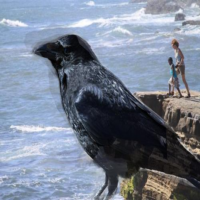

In [ ]:
to_image = torchvision.transforms.ToPILImage()
to_image(next(iter(test_loader))[0].squeeze()[0])

In [ ]:
next(iter(test_loader))[0].squeeze()

tensor([[[[0.2675, 0.3391, 0.3197,  ..., 0.2923, 0.4666, 0.3925],
          [0.3006, 0.3665, 0.3618,  ..., 0.3159, 0.5047, 0.3659],
          [0.2775, 0.3658, 0.3619,  ..., 0.3267, 0.3394, 0.2482],
          ...,
          [0.0819, 0.1514, 0.2360,  ..., 0.7976, 0.5740, 0.1655],
          [0.2273, 0.1637, 0.1929,  ..., 0.9357, 0.5133, 0.1262],
          [0.3615, 0.3426, 0.2790,  ..., 0.9345, 0.4706, 0.1360]],

         [[0.2448, 0.3075, 0.2795,  ..., 0.3262, 0.4785, 0.3932],
          [0.2793, 0.3362, 0.3227,  ..., 0.3427, 0.5138, 0.3694],
          [0.2586, 0.3378, 0.3253,  ..., 0.3566, 0.3528, 0.2537],
          ...,
          [0.1546, 0.2236, 0.3138,  ..., 0.7818, 0.5257, 0.1149],
          [0.3329, 0.2608, 0.2852,  ..., 0.9235, 0.4622, 0.0714],
          [0.4940, 0.4593, 0.3864,  ..., 0.9179, 0.4147, 0.0765]],

         [[0.3275, 0.3833, 0.3433,  ..., 0.2984, 0.4811, 0.4223],
          [0.3539, 0.4053, 0.3807,  ..., 0.3661, 0.5474, 0.3906],
          [0.3204, 0.3953, 0.3687,  ..., 0